# ДЗ1 - имитационное обучение
Крайний срок сдачи - 20.02.2019 23:59.

***
Задача будет заключаться в том, чтобы провести эксперименты с имитационным обучением: смотреть, что такое клонирование поведения и разобраться с алгоритмом DAgger.
Вместо человека-демонстранта демонстрации будут даваться специальной предобученной "экспертной" стратегией. Ваша задача будет заключаться в реализации алгоритма клонирования и DAgger, сравнения их производительности на нескольких простых задачах управления из пакета OpenAI Gym. Ваше решение в виде Jupyter тетрадки *с комментариями* нужно загрузить по [ссылке](https://www.dropbox.com/request/uNq18mDY284JdI7o5KgJ) с шаблоном имени "Фамилия>\_ИАД<номер группы>.ipynb", например Панов_ИАД1.ipynb. Указывать ту группу, которую вы посещаете на семинарах.

__Будьте винимательны!__ В заготовках кода ниже могут быть неточности! Их правка входит в задачу выполнения ДЗ! Как минимум, вам нужно дописывать строчик кода ниже пометок __Ваш код здесь__.

## Требования:
### 1. __TensorFlow:__
Инструкции-напоминания по установке здесь - https://www.tensorflow.org/get_started/os_setup. GPU не будет требоваться для выполнения ДЗ.
### 2. __OpenAI Gym:__  
Напоминание-инструкции по OpenAI Gym - https://gym.openai.com/docs. Используйте версию 0.10.5.
### 3. __MuJoCo:__<br>
Будем использовать набор симуляционных сред MuJoCo.  Загружайте версию 1.50 с http://mujoco.org/,  и версию  1.50.1.56  с https://github.com/openai/mujoco-py/. Для активации доступа можно испоьзовать ваше университетский аккаунт -  https://www.roboti.us/license.html.
***

Импортируем все необходимое:

In [1]:
import os
import pickle
import tensorflow as tf
print("TensorFlow version :",tf.__version__)

import numpy as np
import tf_util
import gym
print("Gym version :",gym.__version__)

import glfw
import load_policy

import matplotlib.pyplot as plt
%matplotlib inline

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow version : 1.12.0
Gym version : 0.10.5


***
## Соберём статистику

 Генерируем статистику (roll-outs) по заданной экспертной стратегии в 3 шага:
 1. Загружаем стратегию из файла и инициализируем окружение.
 2. Начинаем сессию tensorflow.
 3. В рамках сессии собираем данные: до конца эпизода в цикле выбираем экспертное действие, применяем его и сохраняем результаты.

In [2]:
#choose environment (Uncomment choosed one)
env_name="Humanoid-v2"
#env_name="Ant-v2"
#env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
#env_name="Reacher-v2"
#env_name="Walker2d-v2"

# choose expert policy file from /expert file
expert_policy_file="experts/"+ env_name +".pkl"

# load the policy
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

# make the environment
env = gym.make(env_name)

# function to generate rollouts from the expert policies 
def generate_rollouts(num_rollouts,max_steps,render=False, flag = True):
    
    # initialize tensoflow session (tf stuff)
    with tf.Session():
        tf_util.initialize()

        # collect rollouts
        # firstly, define the arrays
        returns = []
        observations = []
        actions = []

        # loop to collect data
        for i in range(num_rollouts):
            #number of iteration (episode)
            #print('iter', i)
            # parameters to initial values
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            # loop until the end of the episode
            while not done:
                # choose an action depending on the observation
                action = policy_fn(obs[None,:])
                # append sample to arrays
                observations.append(obs)
                actions.append(action)
                # apply the action on the environment
                obs, r, done, _ = env.step(action)
                # calculate the total reward
                totalr += r
                steps += 1
                # render the environment
                if render==True:
                    env.render()
                #if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
                if steps >= max_steps:
                    break
            # append the total reward
            returns.append(totalr)
        
        if flag == True: 
        # print the reward information
        #print('returns', returns)
            print('mean return', np.mean(returns))
            print('std of return', np.std(returns))

        expert_data = {'observations': np.array(observations),'actions': np.array(actions)}
            
        return expert_data

loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Тестируем реализованную функцию: num_rollouts=4,max_steps=100,render=True

Notes:
- If the camera doesn't track the agent, prss __Tab__ to change the viewpoint
- In some cases the jupyter notebok kernel will crash if you close the rendering window, __don't close the windows until finishing the execution of the whole notebook.__

In [4]:
generate_rollouts(num_rollouts=4,max_steps=100,render=True);

Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Creating window glfw
mean return 221.54510653735204
std of return 0.6157833434180258


***
## 1. Клонирование поведения

Клонирование поведения (Behavioural cloning, BC) - метод, с помощью которого компьютерная программа обучается воспроизводить действия эксперта (человека). Действия эксперта записываются, а затем эта статистика используется как входные данные для алгоритма обучения. Этот алгоритм в результате формирует последовательность действий, по которым воспроизводится поведение эксперта.

Будем использовать стандартное обучение с учителем и использовать нейронную сеть для этого.

Кроме конструктора, вам нужно дореализовать метод __train__ класса __BC_Model__:

In [3]:
from sklearn.utils import shuffle

class BC_Model(object):
    def __init__(self, input_data, output_data, batch_size = 128):
        
        # define tensorflow session
        self.sess = tf.Session()
        # input and output data , and their shapes
        self.batch_size = batch_size
        self.input_data = input_data
        self.output_data = np.reshape(output_data, (output_data.shape[0], output_data.shape[2]))
        self.input_shape = [self.batch_size, self.input_data.shape[-1]]
        self.output_shape = [self.batch_size, self.output_data.shape[-1]]
        
        # placeholders for the neural network (input, model output and the expert output)
        self.input_placeholder = tf.placeholder(tf.float32, shape = self.input_shape)
        self.output_placeholder_expert = tf.placeholder(tf.float32, shape = self.output_shape)
        self.output_placeholder_model = self.build_model(self.input_placeholder)
        
        # the loss function Mean squared error, (L2 stands for Least Square Errors)
        ### Ваш код здесь - нужно добавить функцию потерь l2_loss ###
        self.loss = tf.losses.mean_squared_error(self.output_placeholder_model, self.output_placeholder_expert)


    def build_model(self, input_placeholder):
        # build the neural network  (you can try another architecture)
        ### Ваш код здесь - нужно реализовать свою архитектуру ###
        layer_1 = tf.layers.dense(inputs=input_placeholder, units=64, activation=tf.nn.relu) 
        layer_2 = tf.layers.dense(inputs = layer_1, units = 128, activation = tf.nn.relu) 
        layer_3 = tf.layers.dense(inputs = layer_2, units = 256, activation = tf.nn.relu) 
        final_layer = tf.layers.dense(inputs = layer_3, units = self.output_placeholder_expert.shape[1],activation = tf.nn.relu)
        
        return final_layer

    def train(self, epochs = 80, train_data = None, test_data = None):
        # check train and test data
        if train_data is None and test_data is None :
            # split the input data to train and test if test and train data are not given
            train_data, test_data = shuffle(self.input_data, self.output_data, random_state = 0)
        else:
            #reshape test data
            test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[2]))
        
        # using Adam optimizer
        optimizer = tf.train.AdamOptimizer().minimize(self.loss)
        # define a saver
        saver = tf.train.Saver()
        
        # number of batches
        batch_idxs = len(train_data) // self.batch_size

        # define a writer ()
        writer = tf.summary.FileWriter("exp")
        
        # add the graph (The model and all the variables) to the writer
        writer.add_graph(self.sess.graph)

        #initialize network variables
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)

        #loop over epochs
        for epoch in range(epochs):
            #for each epoch loop over batches
            for idx in range(batch_idxs):
                # take a batch from training and test data
                batch_train = train_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                batch_value = test_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                # run the optimizer to reduce the loss (we train the model to give us the same output for specific input)
                feed_train = {self.input_placeholder : batch_train, self.output_placeholder_expert : batch_value}
                self.sess.run(optimizer, feed_dict = feed_train)
                    
        # save the model
        saver.save(self.sess, "exp" + "/behavior_cloning_model")

    def sample(self, input):
        #sample an action for a specified input
        output = self.sess.run(self.output_placeholder_model, feed_dict = {self.input_placeholder : np.repeat(input[None, :], self.batch_size, axis = 0)})
        return output[0]

### Обучим модель на экспертных данных

In [4]:
# generate expert data
data=generate_rollouts(num_rollouts=20,max_steps=100,render=False);
x = data['observations']
y = data['actions']
print ('dimension of obs :', x.shape)
print('dimension of actions :', y.shape)

# shuffle data
x,y = shuffle(x,y)

# create an object from BC_Model class, and train it
cloner=BC_Model(x,y)
cloner.train()

Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
mean return 638.1894274553965
std of return 7.596273920743571
dimension of obs : (2000, 376)
dimension of actions : (2000, 1, 17)


### Испытываем модель

In [5]:
num_eval_rollouts=20
# loop over runouts
returns=[]
for i in range(num_eval_rollouts):
    # reset variables in each iteration
    totalr=0
    done=False
    obs=env.reset()
    # loop until the end of the episode
    while not done:
        # get an action from the trained model (output for specific observation as input)
        action=cloner.sample(obs)
        # implement the action
        obs,r,done,_=env.step(action)
        env.render()
        totalr+=r
    returns.append(totalr)
print('mean return', np.mean(returns))
print('std of return', np.std(returns))

Creating window glfw
mean return 197.20863247376093
std of return 5.783683616994509


__Задание 1.1.__ Вам необходимо обучить модель на любых трех окружениях MoJoCo. Построить графики отдачи (totalr) в зависимости от количества набранной статистики (num_rollouts) для обучения.

In [6]:
number_rollouts = range(10,50,5)
rollout_returns = []
for rollout in number_rollouts:
    data=generate_rollouts(num_rollouts=rollout,max_steps=100,render=False, flag = False);
    x = data['observations']
    y = data['actions']
    x,y = shuffle(x,y)
    cloner=BC_Model(x,y)
    cloner.train()
    num_eval_rollouts=20
    returns=[]
    for i in range(num_eval_rollouts):
        totalr=0
        done=False
        obs=env.reset()
        while not done:
            action=cloner.sample(obs)
            obs,r,done,_=env.step(action)
            env.render()
            totalr+=r
        returns.append(totalr)
    print('    Rollouts number: ', rollout)
    print('mean return', np.mean(returns))
    print('std of return:', np.std(returns))
    rollout_returns.append(np.mean(returns))
        

    Rollouts number:  10
mean return 89.30243250215061
std of return: 27.57724850981613
    Rollouts number:  15
mean return 68.0772075771354
std of return: 10.769442119615142
    Rollouts number:  20
mean return 87.17260072304757
std of return: 17.862430864286985
    Rollouts number:  25
mean return 118.92740782591208
std of return: 45.89171901991374
    Rollouts number:  30
mean return 266.4746287621148
std of return: 114.83926625783833
    Rollouts number:  35
mean return 202.39813589526133
std of return: 126.72104010306185
    Rollouts number:  40
mean return 166.9030015871236
std of return: 145.52719662548645
    Rollouts number:  45
mean return 293.80164169342675
std of return: 10.993037212546986


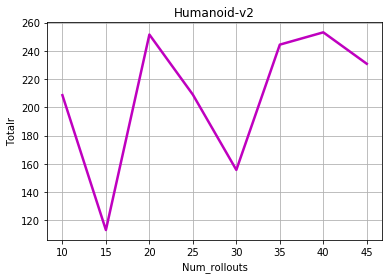

In [36]:
def plot(name):
    plt.plot(number_rollouts, rollout_returns, linestyle='-', linewidth = 2.5, color = 'm')
    plt.title(name)
    plt.xlabel("Num_rollouts") 
    plt.ylabel("Totalr")
    plt.grid()
    plt.show()
plot('Humanoid-v2')

### Hopper - v2

In [126]:
#"Hopper-v2"
def change_env(name):
    env_name= name 
    expert_policy_file="experts/"+ env_name +".pkl"
    print('loading and building expert policy')
    policy_fn = load_policy.load_policy(expert_policy_file)
    print('loaded and built')
    env = gym.make(env_name)
    
change_env("Hopper-v2")

# Не забудьте прогнать после этого код после задания 1.1 !!!

loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


__Не забудьте прогнать код после 1.1__ 

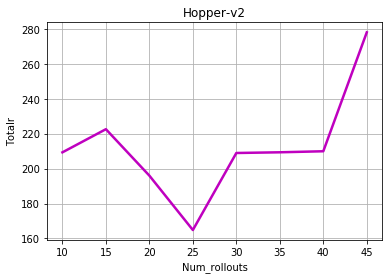

In [132]:
plot('Hopper-v2')

### Walker2d-v2

In [139]:
change_env("Walker2d-v2")

loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


__Не забудьте прогнать код после 1.1__ 

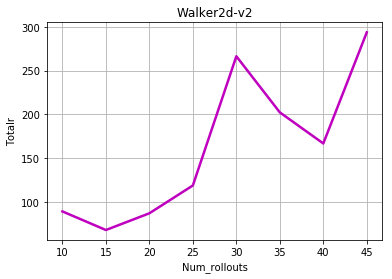

In [7]:
plot("Walker2d-v2")

__Задание 1.2.__ Выберите один из гиперапараметров вашей модели, которые влияют на качество обучения (количество эпох, количество слоев и т.п.). Для одного из окружений постройте график влияния значения этого параметра на качество обучения (totalr).

__Окружение возьмём Humanoid-v2, гиперпараметр - количество эпох __ 

In [9]:
num_epoch=range(10, 200, 10)
num_eval_rollouts=20 
returns_epo=[] 
for epoch in num_epoch: 
    cloner=BC_Model(x,y) 
    cloner.train(epochs = epoch) 
    returns=[] 
    for i in range(num_eval_rollouts):
        totalr=0
        done=False
        obs=env.reset()
        while not done:
            action=cloner.sample(obs)
            obs,r,done,_=env.step(action)
            env.render()
            totalr+=r
        returns.append(totalr)
    print('mean return', np.mean(returns))
    print('std of return', np.std(returns))
    returns_epo.append(np.mean(returns))

mean return 159.86133151341897
std of return 5.249913158525813
mean return 113.50456847550349
std of return 2.4955808268038706
mean return 210.8770623300142
std of return 3.1345539014423354
mean return 210.23646550723146
std of return 2.937009350157578
mean return 253.98401067850006
std of return 6.075019774318321
mean return 211.0876857924987
std of return 2.9186952629992935
mean return 209.62230805045516
std of return 2.4158354041247727
mean return 307.74890429880384
std of return 25.49611424868148
mean return 202.17594557052223
std of return 9.076418247496436
mean return 319.7675323103047
std of return 12.654167695905693
mean return 322.43734826235095
std of return 14.911264142395865
mean return 269.5982799611679
std of return 5.078835811583728
mean return 189.2151913315435
std of return 1.8857257738045083
mean return 299.2079161507972
std of return 18.190599037701656
mean return 287.0693657605296
std of return 11.682365527184373
mean return 419.03542344133774
std of return 23.73724

Text(0.5,1,'Humanoid-v2')

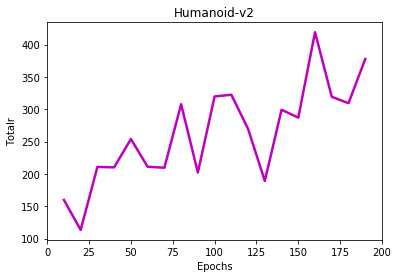

In [16]:
plt.plot(range(10, 200, 10), returns_epo, linestyle='-', linewidth = 2.5, color = 'm')
plt.xlim(0,200)
plt.xlabel("Epochs") 
plt.ylabel("Totalr") 
plt.title(env_name) 

***
## 2. DAgger Algorithm

Цель алгоритма DAgger (data Aggregation) - собрать статистику обучаемой модели, вместо экспертных данных. 
- Вначале мы тренируем BC_Model на собранных экспертных данных.
- Запускаем модель на окружение, собираем наблюдения.
- Затем мы просим эксперта (человека) отметить, какие действия нужно совершать в полученных наблюдениях (по сути используем __policy_fn__).
- Создаем новую коллекцию помеченных и экспертных данных.
- Потворяем.

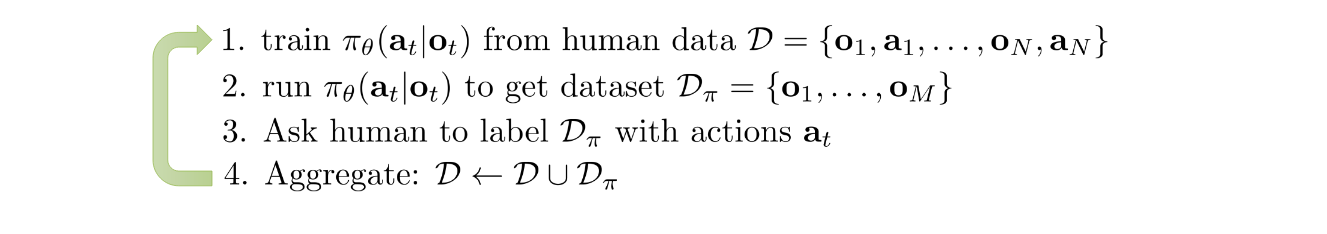

In [8]:
with tf.Session():
    DAgger_iter=20
    render=False
    # DAgger loop
    for i in range(DAgger_iter):
        # reset in each iteration
        new_obs = []
        new_actions = []
        obs = env.reset()
        done = False
        # collect data from model and expert
        while not done:
            # get an action from the model
            ### Ваш код здесь - испольузуем обученную модель ###
            action = cloner.sample(obs)
            
            obs, _, done, _ = env.step(action)
            if render:
                env.render()
            # get the expert action for the same input
            ### Ваш код здесь - используем policy_fn!! ###
            corrected_action = policy_fn(obs[None,:])
            
            # append the observation and expert action to the data set
            new_obs.append(obs)
            new_actions.append(corrected_action)
        # re-order the data
        x = np.concatenate((x, obs[None, :]), axis = 0)
        y = np.concatenate((y, corrected_action[None, :]), axis = 0)
        # train the model on the collected data
        ### Ваш код здесь - дообучаем модель ###
        #cloner.train...
        cloner.train(train_data = x, test_data = y)

### Проверяем работу

In [9]:
num_eval_rollouts=20
# loop over runouts
returns=[]
for i in range(num_eval_rollouts):
    # reset variables in each iteration
    totalr=0
    done=False
    obs=env.reset()
    # loop until the end of the episode
    while not done:
        # get an action from the trained model (output for specific observation as input)
        action=cloner.sample(obs)
        # implement the action
        obs,r,done,_=env.step(action)
        env.render()
        totalr+=r
    returns.append(totalr)
print('mean return', np.mean(returns))
print('std of return', np.std(returns))

mean return 328.47880344274944
std of return 20.50477331513599


__Задание 2.1.__ Проверьте работу DAagger на всех задачах MoJoCo - укажите для какой задачи он работает лучше, чем простое клонирование. Покажите это на графиках.

### Humanoid-V2

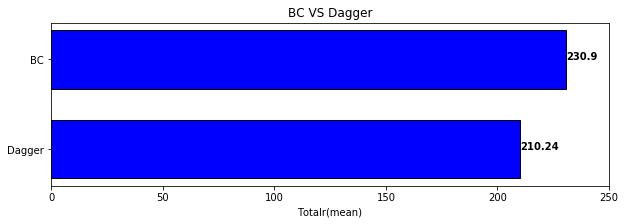

In [125]:
fig, ax = plt.subplots(figsize=(10, 3))

algorithms = ('BC', 'Dagger')
y_pos = np.arange(len(algorithms))
outputs = list(np.around(np.array([rollout_returns[-1], np.mean(returns)]),2))
width = 0.65
ax.barh(y_pos, outputs, width, align='center',
        color='blue', edgecolor = 'black')
ax.set_yticks(y_pos)
ax.set_yticklabels(algorithms)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set(xlim=(0, 250), ylabel="",
       xlabel="Totalr(mean)")
ax.set_title('BC VS Dagger')

for i, v in enumerate(outputs):
    ax.text(v, i, str(v), color='black', fontweight='bold')
plt.show()

#### Для среды Humanoid-V2 обычный BC работает лучше, чем Dagger

### Hopper-v2

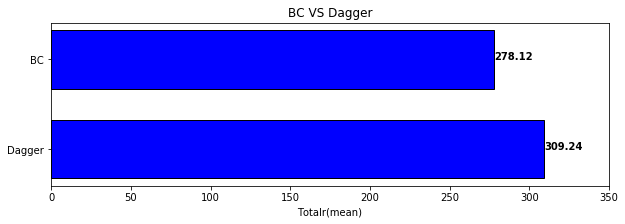

In [136]:
fig, ax = plt.subplots(figsize=(10, 3))

algorithms = ('BC', 'Dagger')
y_pos = np.arange(len(algorithms))
outputs = list(np.around(np.array([rollout_returns[-1], np.mean(returns)]),2))
width = 0.65
ax.barh(y_pos, outputs, width, align='center',
        color='blue', edgecolor = 'black')
ax.set_yticks(y_pos)
ax.set_yticklabels(algorithms)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set(xlim=(0, 350), ylabel="",
       xlabel="Totalr(mean)")
ax.set_title('BC VS Dagger')

for i, v in enumerate(outputs):
    ax.text(v, i, str(v), color='black', fontweight='bold')
plt.show()

### Walker2d-v2

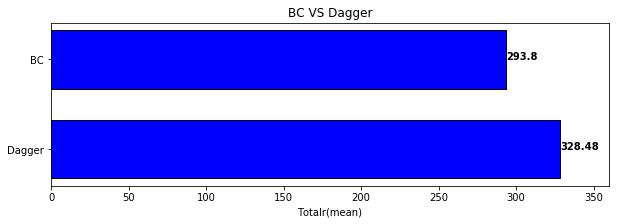

In [13]:
fig, ax = plt.subplots(figsize=(10, 3))

algorithms = ('BC', 'Dagger')
y_pos = np.arange(len(algorithms))
outputs = list(np.around(np.array([rollout_returns[-1], np.mean(returns)]),2))
width = 0.65
ax.barh(y_pos, outputs, width, align='center',
        color='blue', edgecolor = 'black')
ax.set_yticks(y_pos)
ax.set_yticklabels(algorithms)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set(xlim=(0, 360), ylabel="",
       xlabel="Totalr(mean)")
ax.set_title('BC VS Dagger')

for i, v in enumerate(outputs):
    ax.text(v, i, str(v), color='black', fontweight='bold')
plt.show()

#### Для сред Hopper-v2 и Walker2d-v2 Dagger работает лучше, чем обычный BC